# PART 1 data cleaning 

### 1. Import the required packages

In [14]:
## 导入所需要的包 / Import the required packages

# 基础操作
import pandas as pd

# 数据预处理
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# 数据拆分
from sklearn.model_selection import train_test_split

# 数据平衡处理
from imblearn.under_sampling import RandomUnderSampler

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

# 机器学习模型
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression


# 模型评估
from sklearn.metrics import accuracy_score, precision_score, f1_score

# 模型存储与加载
import joblib
from joblib import dump, load

# 解释性分析
import shap


### 2. Read file

In [16]:
#   Read CSV file
df = pd.read_csv("../data/Complete_diabetes_prediction_dataset.csv")
df = pd.DataFrame(df)

In [17]:
#  View the first 5 rows of data
print(df.head())

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


In [18]:
# View basic information of data (including data types and missing values)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None


In [19]:
# Descriptive statistics
print(df.describe())

                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.636783   
min         0.080000       0.00000       0.000000      10.010000   
25%        24.000000       0.00000       0.000000      23.630000   
50%        43.000000       0.00000       0.000000      27.320000   
75%        60.000000       0.00000       0.000000      29.580000   
max        80.000000       1.00000       1.000000      95.690000   

         HbA1c_level  blood_glucose_level       diabetes  
count  100000.000000        100000.000000  100000.000000  
mean        5.527507           138.058060       0.085000  
std         1.070672            40.708136       0.278883  
min         3.500000            80.000000       0.000000  
25%         4.800000           100.000000       0.000000  
50%         5.800000           14

### 3. Check for missing values

In [20]:
# Check for missing values in each column
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


### 4. Check for duplicate values

In [21]:
#  Check for duplicate values in the data box
duplicate_rows = df[df.duplicated()]

#  Display all duplicate rows
print(duplicate_rows)

       gender   age  hypertension  heart_disease smoking_history    bmi  \
2756     Male  80.0             0              0         No Info  27.32   
3272   Female  80.0             0              0         No Info  27.32   
3418   Female  19.0             0              0         No Info  27.32   
3939   Female  78.0             1              0          former  27.32   
3960     Male  47.0             0              0         No Info  27.32   
...       ...   ...           ...            ...             ...    ...   
99980  Female  52.0             0              0           never  27.32   
99985    Male  25.0             0              0         No Info  27.32   
99989  Female  26.0             0              0         No Info  27.32   
99990    Male  39.0             0              0         No Info  27.32   
99995  Female  80.0             0              0         No Info  27.32   

       HbA1c_level  blood_glucose_level  diabetes  
2756           6.6                  159        

In [22]:
# Delete all duplicate rows, retaining only the first one that appears
df = df.drop_duplicates()

### 5. Handling Extreme Values

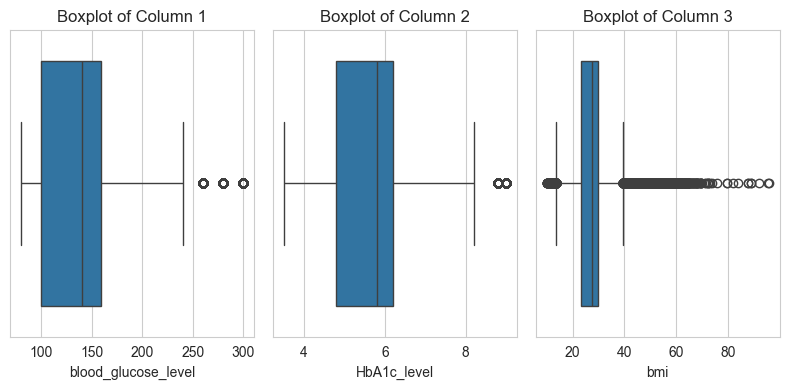

In [23]:
# Create a layout with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))

# 绘制第三个箱线图 / Draw the third box line diagram
sns.boxplot(x=df['blood_glucose_level'], ax=axes[0])
axes[0].set_title('Boxplot of Column 1')

sns.boxplot(x=df['HbA1c_level'], ax=axes[1])
axes[1].set_title('Boxplot of Column 2')

sns.boxplot(x=df['bmi'], ax=axes[2])
axes[2].set_title('Boxplot of Column 3')

# 自动调整子图间距 / Automatically adjust the spacing between subgraphs
plt.tight_layout()

# 显示图形 / plot show
plt.show()

In [24]:
# 计算并打印极值的函数
def calculate_outliers(column):
    data = df[column]
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return len(outliers), len(data)

# 对每个特征进行分析
columns = ['blood_glucose_level', 'HbA1c_level', 'bmi']
for col in columns:
    outlier_count, total = calculate_outliers(col)
    print(f"{col}:")
    print(f"极值数量: {outlier_count}")
    print(f"极值百分比: {outlier_count/total*100:.2f}%")
    print("-"*30)

blood_glucose_level:
极值数量: 2031
极值百分比: 2.11%
------------------------------
HbA1c_level:
极值数量: 1312
极值百分比: 1.36%
------------------------------
bmi:
极值数量: 5354
极值百分比: 5.57%
------------------------------


In [25]:
 # 假设你在 DataFrame 中的列名为 'hypertension' / Assuming your column name in the DataFrame is' tension '
Q1 = df['blood_glucose_level'].quantile(0.25)
Q3 = df['blood_glucose_level'].quantile(0.75)
IQR = Q3 - Q1

# 计算上边界和下边界 / Calculate the upper and lower boundaries
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# 将异常值替换为中位数 / Replace outliers with medians
df.loc[df['blood_glucose_level'] > upper_bound, 'blood_glucose_level'] = df['blood_glucose_level'].median()
df.loc[df['blood_glucose_level'] < lower_bound, 'blood_glucose_level'] = df['blood_glucose_level'].median()

In [26]:
# 假设你在 DataFrame 中的列名为 'hypertension' / Assuming your column name in the DataFrame is' tension '
Q1 = df['HbA1c_level'].quantile(0.25)
Q3 = df['HbA1c_level'].quantile(0.75)
IQR = Q3 - Q1

# 计算上边界和下边界 / Calculate the upper and lower boundaries
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# 将异常值替换为中位数
df.loc[df['HbA1c_level'] > upper_bound, 'HbA1c_level'] = df['HbA1c_level'].median()
df.loc[df['HbA1c_level'] < lower_bound, 'HbA1c_level'] = df['HbA1c_level'].median()

In [27]:
# 假设你在 DataFrame 中的列名为 'hypertension'
Q1 = df['bmi'].quantile(0.25)
Q3 = df['bmi'].quantile(0.75)
IQR = Q3 - Q1

# 计算上边界和下边界
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# 将异常值替换为中位数
df.loc[df['bmi'] > upper_bound, 'bmi'] = df['bmi'].median()
df.loc[df['bmi'] < lower_bound, 'bmi'] = df['bmi'].median()

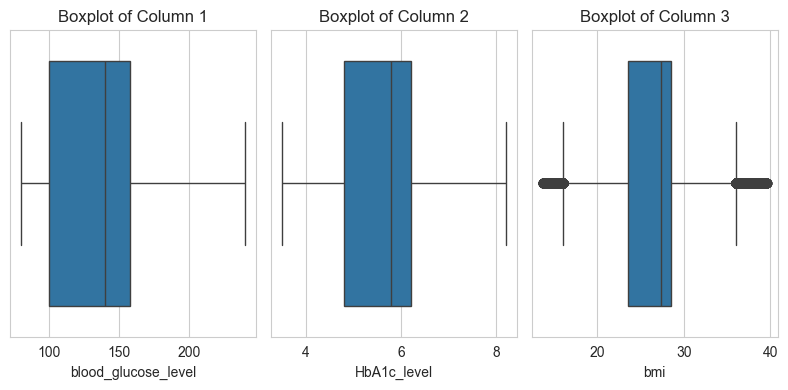

In [28]:
# 创建 2 行 2 列的布局
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,4))

# 绘制第三个箱线图
sns.boxplot(x=df['blood_glucose_level'], ax=axes[0])
axes[0].set_title('Boxplot of Column 1')

sns.boxplot(x=df['HbA1c_level'], ax=axes[1])
axes[1].set_title('Boxplot of Column 2')

sns.boxplot(x=df['bmi'], ax=axes[2])
axes[2].set_title('Boxplot of Column 3')

# 自动调整子图间距
plt.tight_layout()

# 显示图形
plt.show()

### 6.独热编码转化

In [29]:
# 创建 OneHotEncoder 实例
encoder = OneHotEncoder(sparse_output=False)  # 旧版参数 sparse=False 已被替换

# 将 'gender' 和 'smoking_history' 列转换为独热编码
encoded_gender_smoking = encoder.fit_transform(df[['gender', 'smoking_history']])

# 将编码后的数据转换为 DataFrame，添加列名
encoded_df = pd.DataFrame(encoded_gender_smoking, 
                          columns=encoder.get_feature_names_out(['gender', 'smoking_history']))

# 合并原 DataFrame 和编码后的 DataFrame
df = pd.concat([df, encoded_df], axis=1)

# 删除 'gender' 和 'smoking_history' 列
df = df.drop(['gender', 'smoking_history'], axis=1)

# 打印合并后的 DataFrame
print(df)

        age  hypertension  heart_disease    bmi  HbA1c_level  \
0      80.0           0.0            1.0  25.19          6.6   
1      54.0           0.0            0.0  27.32          6.6   
2      28.0           0.0            0.0  27.32          5.7   
3      36.0           0.0            0.0  23.45          5.0   
4      76.0           1.0            1.0  20.14          4.8   
...     ...           ...            ...    ...          ...   
96076   NaN           NaN            NaN    NaN          NaN   
96085   NaN           NaN            NaN    NaN          NaN   
96125   NaN           NaN            NaN    NaN          NaN   
96126   NaN           NaN            NaN    NaN          NaN   
96133   NaN           NaN            NaN    NaN          NaN   

       blood_glucose_level  diabetes  gender_Female  gender_Male  \
0                    140.0       0.0            1.0          0.0   
1                     80.0       0.0            1.0          0.0   
2                    158.0 

In [30]:
# 检查每列是否有缺失值
print(df.isnull().sum())

age                            3585
hypertension                   3585
heart_disease                  3585
bmi                            3585
HbA1c_level                    3585
blood_glucose_level            3585
diabetes                       3585
gender_Female                  3585
gender_Male                    3585
gender_Other                   3585
smoking_history_No Info        3585
smoking_history_current        3585
smoking_history_ever           3585
smoking_history_former         3585
smoking_history_never          3585
smoking_history_not current    3585
dtype: int64


In [31]:
df= df.dropna(axis=0, how='any')

In [32]:
# 检查每列是否有缺失值
print(df.isnull().sum())

age                            0
hypertension                   0
heart_disease                  0
bmi                            0
HbA1c_level                    0
blood_glucose_level            0
diabetes                       0
gender_Female                  0
gender_Male                    0
gender_Other                   0
smoking_history_No Info        0
smoking_history_current        0
smoking_history_ever           0
smoking_history_former         0
smoking_history_never          0
smoking_history_not current    0
dtype: int64


In [33]:
# 查看数据基本信息（包括数据类型和缺失值情况）
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 92561 entries, 0 to 96145
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          92561 non-null  float64
 1   hypertension                 92561 non-null  float64
 2   heart_disease                92561 non-null  float64
 3   bmi                          92561 non-null  float64
 4   HbA1c_level                  92561 non-null  float64
 5   blood_glucose_level          92561 non-null  float64
 6   diabetes                     92561 non-null  float64
 7   gender_Female                92561 non-null  float64
 8   gender_Male                  92561 non-null  float64
 9   gender_Other                 92561 non-null  float64
 10  smoking_history_No Info      92561 non-null  float64
 11  smoking_history_current      92561 non-null  float64
 12  smoking_history_ever         92561 non-null  float64
 13  smoking_history_forme

In [34]:
# 描述性统计
print(df.describe())

                age  hypertension  heart_disease           bmi   HbA1c_level  \
count  92561.000000  92561.000000   92561.000000  92561.000000  92561.000000   
mean      41.779180      0.077376       0.040600     26.462067      5.489233   
std       22.462138      0.267189       0.197363      5.085449      0.998316   
min        0.080000      0.000000       0.000000     13.710000      3.500000   
25%       24.000000      0.000000       0.000000     23.510000      4.800000   
50%       43.000000      0.000000       0.000000     27.320000      5.800000   
75%       59.000000      0.000000       0.000000     28.460000      6.200000   
max       80.000000      1.000000       1.000000     39.550000      8.200000   

       blood_glucose_level      diabetes  gender_Female   gender_Male  \
count         92561.000000  92561.000000   92561.000000  92561.000000   
mean            135.215955      0.088115       0.584123      0.415693   
std              35.092571      0.283463       0.492875     

In [35]:
# 获取所有列名
columns = df.columns.tolist()

# 将第 7 列（索引 6）移动到最后一列
columns = columns[:6] + columns[7:] + [columns[6]]

# 重新排列列顺序
df = df[columns]

C:\Users\29548\AppData\Local\Temp\ipykernel_44164\15261791.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


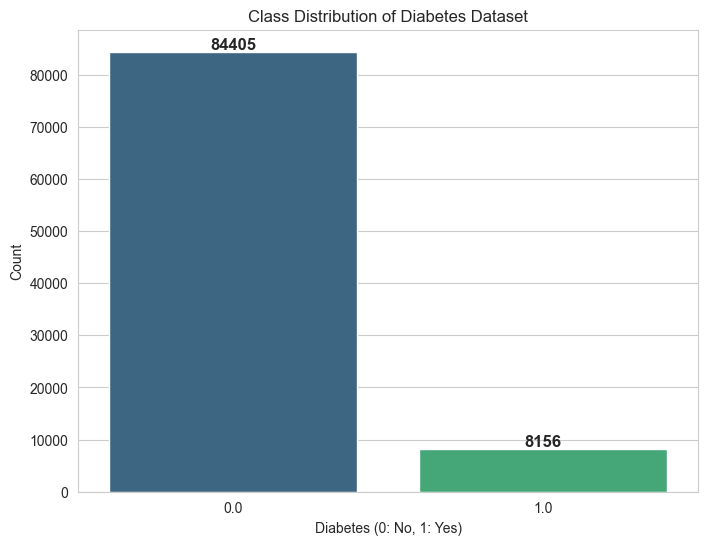

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# 计算目标变量的分布
class_distribution = df['diabetes'].value_counts()

# 画条形图
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')

# 在每个条形上方添加数值标签
for i, value in enumerate(class_distribution.values):
    plt.text(i, value + 500, str(value), ha='center', fontsize=12, fontweight='bold')

# 设置标题和标签
plt.title('Class Distribution of Diabetes Dataset')
plt.xlabel('Diabetes (0: No, 1: Yes)')
plt.ylabel('Count')

# 显示图表
plt.show()


C:\Users\29548\AppData\Local\Temp\ipykernel_44164\3232002150.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df_resampled['diabetes'], palette='viridis')


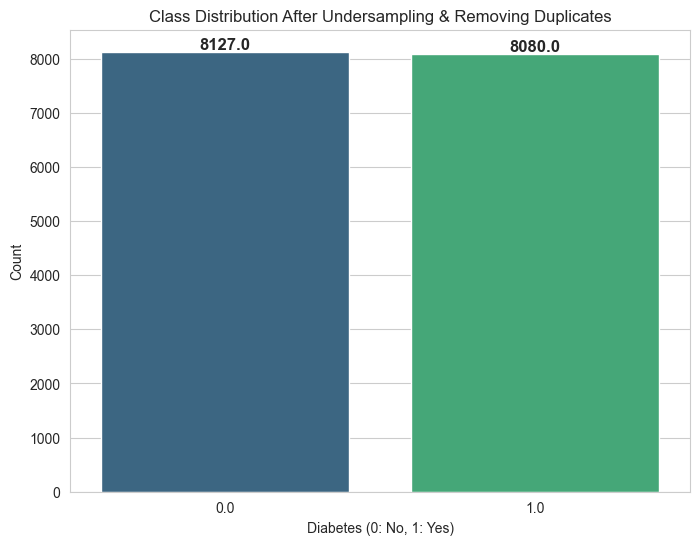

In [43]:

# 1. 预处理数据
X = df.drop('diabetes', axis=1)  # 特征
y = df['diabetes']  # 目标变量

# 2. 进行随机降采样
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# 3. 组合为新的 DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled), pd.Series(y_resampled, name='diabetes')], axis=1)

# 4. 删除重复样本
df_resampled = df_resampled.drop_duplicates()

# 5. 可视化降采样后的类别分布
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=df_resampled['diabetes'], palette='viridis')

# 在每个条形上方添加数值
for p in ax.patches:
    height = p.get_height()  # 获取条形的高度（即样本数量）
    ax.text(p.get_x() + p.get_width() / 2, height + 50, str(height), 
            ha='center', fontsize=12, fontweight='bold')

# 设置标题和标签
plt.title('Class Distribution After Undersampling & Removing Duplicates')
plt.xlabel('Diabetes (0: No, 1: Yes)')
plt.ylabel('Count')

# 显示图表
plt.show()



In [38]:
# 统计去重后的类别数量
class_counts = df_resampled['diabetes'].value_counts()

# 打印每个类别的数量
print("每个类别的样本数量：")
print(class_counts)

每个类别的样本数量：
diabetes
0.0    8127
1.0    8080
Name: count, dtype: int64


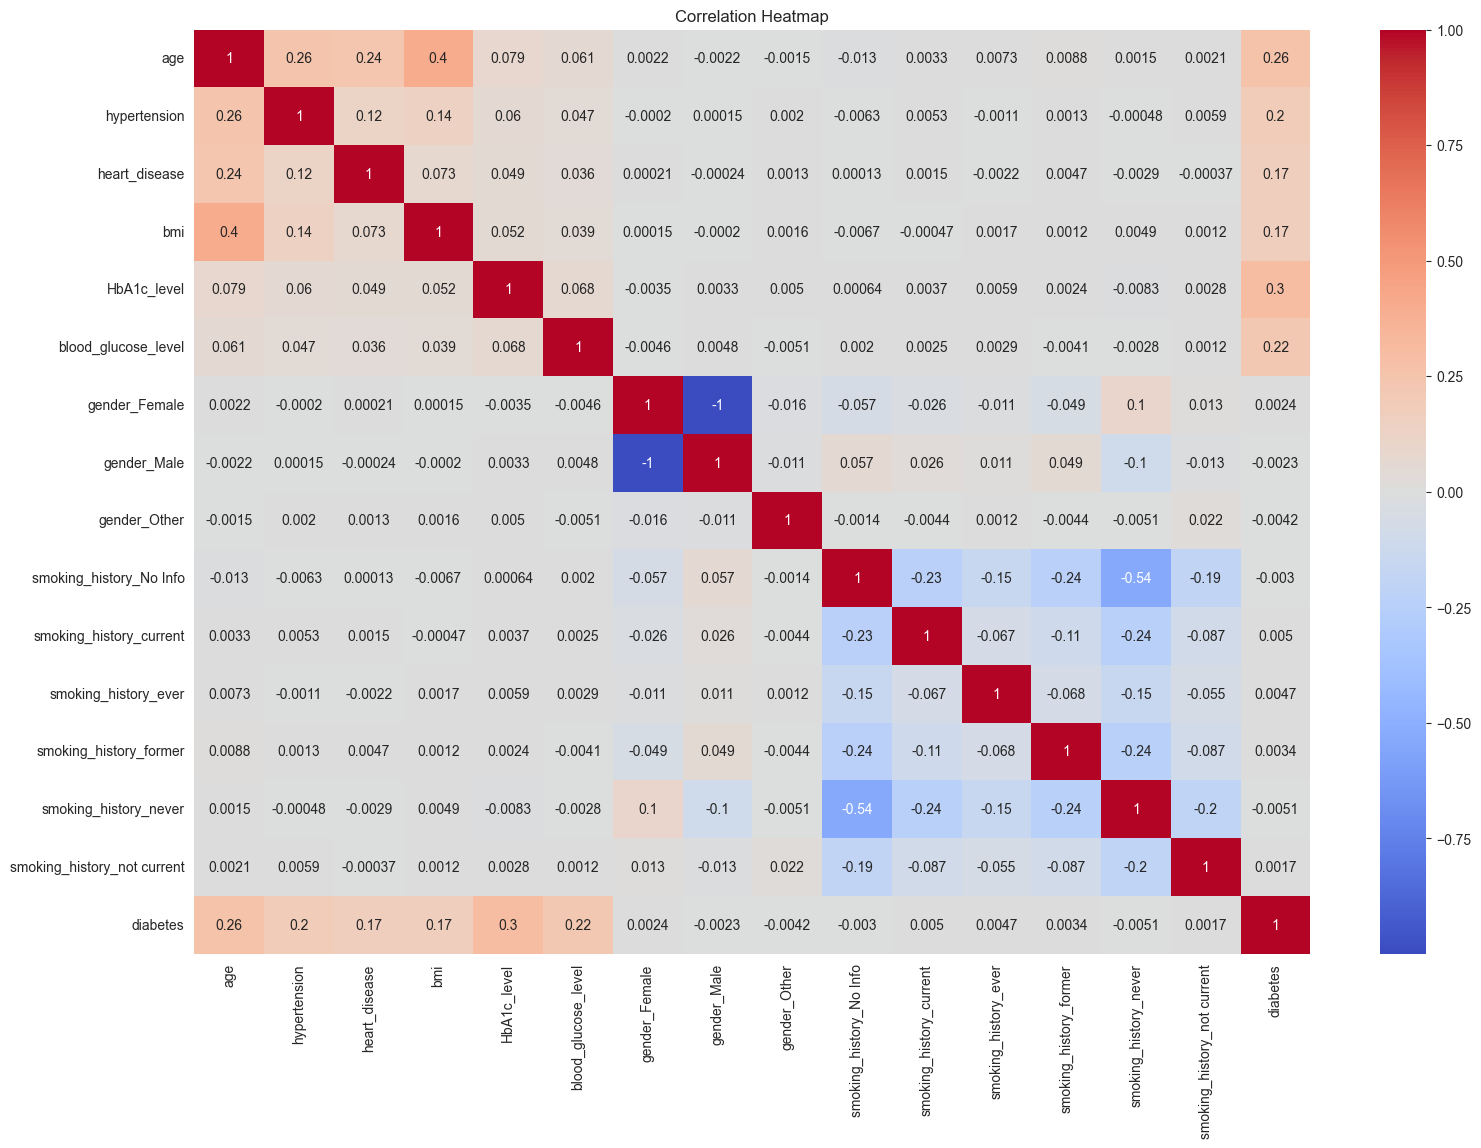

In [41]:
plt.figure(figsize=(18, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [28]:
X = df_resampled.iloc[:, :-1]  # 特征
y = df_resampled.iloc[:, -1]   # 标签
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 重新组合为完整的数据集
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# 保存分割后的数据集
train_data.to_csv("../data/train_data.csv", index=False)
test_data.to_csv("../data/test_data.csv", index=False)

print("save as train_dataset.csv and test_dataset.csv")

save as train_dataset.csv and test_dataset.csv


# Part2: Modelling 

## 1. Import training and testing sets

In [2]:

# Import training dataset / 导入训练集
train_df = pd.read_csv('../data/train_data.csv')
Y_train = train_df['diabetes']  # Target variable for training dataset / 训练集目标变量
X_train = train_df.iloc[:, :-1]  # Select all rows and all columns except the last one / 选择所有行和除了最后一列以外的所有列

# Import testing dataset / 导入测试集
test_df = pd.read_csv('../data/test_data.csv')
Y_test = test_df['diabetes']  # Target variable for testing dataset / 测试集目标变量
X_test = test_df.iloc[:, :-1]  # Select all rows and all columns except the last one / 选择所有行和除了最后一列以外的所有列 

In [3]:
# Output the result / 输出结果
print("Training dataset features:", X_train.shape)  # 训练集特征
print("Testing dataset features:", X_test.shape)  # 测试集特征
print("Training dataset target:", Y_train.shape)  # 训练集目标
print("Testing dataset target:", Y_test.shape)  # 测试集目标

Training dataset features: (12965, 15)
Testing dataset features: (3242, 15)
Training dataset target: (12965,)
Testing dataset target: (3242,)


In [4]:
# 假设 X_train 和 X_test 是已经划分好的训练集和测试集（DataFrame格式）

# 保存列名
columns = X_train.columns

# 初始化StandardScaler
scaler = StandardScaler()

# 对训练集进行标准化（fit + transform）
X_train = scaler.fit_transform(X_train)

# 对测试集进行标准化（仅 transform，防止数据泄漏）
X_test = scaler.transform(X_test)

# 转换回DataFrame，并指定列名
X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

In [5]:
# 输出标准化后的数据形状
print("Standardized Training dataset features:", X_train.shape)
print("Standardized Testing dataset features:", X_test.shape)

# 打印标准化后的训练集和测试集的前五行
print("\nStandardized Training Data (First 5 rows):")
print(X_train.head())

print("\nStandardized Testing Data (First 5 rows):")
print(X_test.head())

Standardized Training dataset features: (12965, 15)
Standardized Testing dataset features: (3242, 15)

Standardized Training Data (First 5 rows):
        age  hypertension  heart_disease       bmi  HbA1c_level  \
0  0.017017     -0.430485      -0.317608  0.730781     0.272778   
1 -2.089375     -0.430485      -0.317608 -2.167479     0.174079   
2 -1.434053     -0.430485      -0.317608 -0.099294     0.568873   
3  0.999999     -0.430485      -0.317608  0.296742     1.062365   
4 -1.902140     -0.430485      -0.317608 -0.099294     0.272778   

   blood_glucose_level  gender_Female  gender_Male  gender_Other  \
0            -1.272030       0.841661    -0.841661           0.0   
1             1.448857      -1.188126     1.188126           0.0   
2             0.333293       0.841661    -0.841661           0.0   
3             0.360502       0.841661    -0.841661           0.0   
4            -0.047631       0.841661    -0.841661           0.0   

   smoking_history_No Info  smoking_histor

In [6]:
# 检查是否有重复行
duplicates = X_train.index.isin(X_test.index)
print("Number of duplicate samples:", sum(duplicates))

Number of duplicate samples: 3242


In [7]:
# 删除重复行（X_train 和 Y_train 同步）
X_train = X_train[~duplicates]
Y_train = Y_train[~duplicates]

In [8]:
# 检查是否有重复行
duplicates = X_train.index.isin(X_test.index)
print("Number of duplicate samples:", sum(duplicates))

Number of duplicate samples: 0


In [9]:
# 输出标准化后的数据形状
print("Standardized Training dataset features:", X_train.shape)
print("Standardized Testing dataset features:", X_test.shape)

# 打印标准化后的训练集和测试集的前五行
print("\nStandardized Training Data (First 5 rows):")
print(X_train.head())

print("\nStandardized Testing Data (First 5 rows):")
print(X_test.head())

Standardized Training dataset features: (9723, 15)
Standardized Testing dataset features: (3242, 15)

Standardized Training Data (First 5 rows):
           age  hypertension  heart_disease       bmi  HbA1c_level  \
3242  0.251060      2.322962      -0.317608  1.138817    -0.122016   
3243 -1.340436     -0.430485      -0.317608  0.864793     0.864969   
3244 -1.527670     -0.430485      -0.317608 -0.419323    -1.405096   
3245 -0.497879      2.322962      -0.317608 -0.099294     0.568873   
3246  0.251060      2.322962      -0.317608  0.820789     0.864969   

      blood_glucose_level  gender_Female  gender_Male  gender_Other  \
3242             2.537212       0.841661    -0.841661           0.0   
3243            -0.183675      -1.188126     1.188126           0.0   
3244             0.224458       0.841661    -0.841661           0.0   
3245            -1.544118       0.841661    -0.841661           0.0   
3246            -0.183675       0.841661    -0.841661           0.0   

      s

## 2. Model selection and training
Firstly we will select the right algorithm according to our requirement and then we will train data on model

In [10]:
# 定义所有模型的配置（名称、模型类、参数）
model_configs = [
    {
        'name': 'Random Forest',
        'class': RandomForestClassifier,
        'params': {'n_estimators': 50, 
                   'random_state': 5, 
                   'max_depth' : 2,
                   'min_samples_split':2,
                   'min_samples_leaf':4}
    },
    {
        'name': 'AdaBoost',
        'class': AdaBoostClassifier,
        'params': {'n_estimators': 30, 'random_state': 5}
    },
    {
        'name': 'XGBoost',
        'class': XGBClassifier,
        'params': {'n_estimators': 50, 'random_state': 42}
    }, 
    {
        'name': 'CatBoost',
        'class': CatBoostClassifier,
        'params': {'iterations': 50, 'learning_rate': 0.1, 'depth': 6, 'random_state': 42, 'verbose': 0}
    }
]

In [48]:
# 统一训练并评估每个模型
for config in model_configs:
    model_name = config['name']
    model = config['class'](**config['params'])
    
    # 训练模型
    model.fit(X_train, Y_train)
    
    # 预测测试集
    Y_pred_test = model.predict(X_test)
    # 预测训练集
    Y_pred_train = model.predict(X_train)  # 新增：预测训练集
    
    # 计算测试集指标
    acc_test = accuracy_score(Y_test, Y_pred_test)
    pre_test = precision_score(Y_test, Y_pred_test, average='weighted')
    f1_test = f1_score(Y_test, Y_pred_test, average='weighted')
    
    # 计算训练集指标
    acc_train = accuracy_score(Y_train, Y_pred_train)  # 新增
    pre_train = precision_score(Y_train, Y_pred_train, average='weighted')  # 新增
    f1_train = f1_score(Y_train, Y_pred_train, average='weighted')  # 新增
    
    # 打印结果（对比训练集和测试集）
    print(f"\n=== {model_name} ===")
    print("[训练集] Accuracy: {:.4f}, Precision: {:.4f}, F1-Score: {:.4f}".format(acc_train, pre_train, f1_train))
    print("[测试集] Accuracy: {:.4f}, Precision: {:.4f}, F1-Score: {:.4f}".format(acc_test, pre_test, f1_test))


=== Random Forest ===
[训练集] Accuracy: 0.8611, Precision: 0.8640, F1-Score: 0.8608
[测试集] Accuracy: 0.8510, Precision: 0.8538, F1-Score: 0.8507

=== AdaBoost ===
[训练集] Accuracy: 0.8923, Precision: 0.8937, F1-Score: 0.8922
[测试集] Accuracy: 0.8846, Precision: 0.8865, F1-Score: 0.8845

=== XGBoost ===
[训练集] Accuracy: 0.9288, Precision: 0.9302, F1-Score: 0.9288
[测试集] Accuracy: 0.8868, Precision: 0.8888, F1-Score: 0.8866


c:\Users\29548\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



=== CatBoost ===
[训练集] Accuracy: 0.8963, Precision: 0.8994, F1-Score: 0.8961
[测试集] Accuracy: 0.8871, Precision: 0.8912, F1-Score: 0.8868


In [40]:
import joblib

# 遍历所有模型配置
for config in model_configs:
    model_name = config['name']
    model = config['class'](**config['params'])
    
    # 训练模型
    model.fit(X_train, Y_train)
    
    # 保存模型
    joblib.dump(model, f'{model_name.lower().replace(" ", "_")}_model.pkl')
    print(f"Model {model_name} saved successfully.")

Model Random Forest saved successfully.
Model AdaBoost saved successfully.


c:\Users\29548\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model Gradient Boosting saved successfully.
Model XGBoost saved successfully.
Model CatBoost saved successfully.


## 3. Use grid search to search for the best hyperparameters

## 4. Model Testing 

In [49]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, f1_score

# 遍历所有模型配置
for config in model_configs:
    model_name = config['name']
    
    # 加载保存的最佳模型
    best_model = joblib.load(f'{model_name.lower().replace(" ", "_")}_model.pkl')
    
    # 使用最佳模型进行预测（测试集）
    Y_pred_test = best_model.predict(X_test)
    
    # 使用最佳模型进行预测（训练集）
    Y_pred_train = best_model.predict(X_train)
    
    # 计算测试集指标
    acc_test = accuracy_score(Y_test, Y_pred_test)
    pre_test = precision_score(Y_test, Y_pred_test, average='weighted')
    f1_test = f1_score(Y_test, Y_pred_test, average='weighted')
    
    # 计算训练集指标
    acc_train = accuracy_score(Y_train, Y_pred_train)
    pre_train = precision_score(Y_train, Y_pred_train, average='weighted')
    f1_train = f1_score(Y_train, Y_pred_train, average='weighted')
    
    # 打印结果
    print(f"\n=== {model_name} ===")
    print("[train data] Accuracy: {:.4f}, Precision: {:.4f}, F1-Score: {:.4f}".format(acc_train, pre_train, f1_train))
    print("[test data] Accuracy: {:.4f}, Precision: {:.4f}, F1-Score: {:.4f}".format(acc_test, pre_test, f1_test))


=== Random Forest ===
[train data] Accuracy: 0.8611, Precision: 0.8640, F1-Score: 0.8608
[test data] Accuracy: 0.8510, Precision: 0.8538, F1-Score: 0.8507

=== AdaBoost ===
[train data] Accuracy: 0.8923, Precision: 0.8937, F1-Score: 0.8922
[test data] Accuracy: 0.8846, Precision: 0.8865, F1-Score: 0.8845

=== XGBoost ===
[train data] Accuracy: 0.9288, Precision: 0.9302, F1-Score: 0.9288
[test data] Accuracy: 0.8868, Precision: 0.8888, F1-Score: 0.8866

=== CatBoost ===
[train data] Accuracy: 0.8963, Precision: 0.8994, F1-Score: 0.8961
[test data] Accuracy: 0.8871, Precision: 0.8912, F1-Score: 0.8868


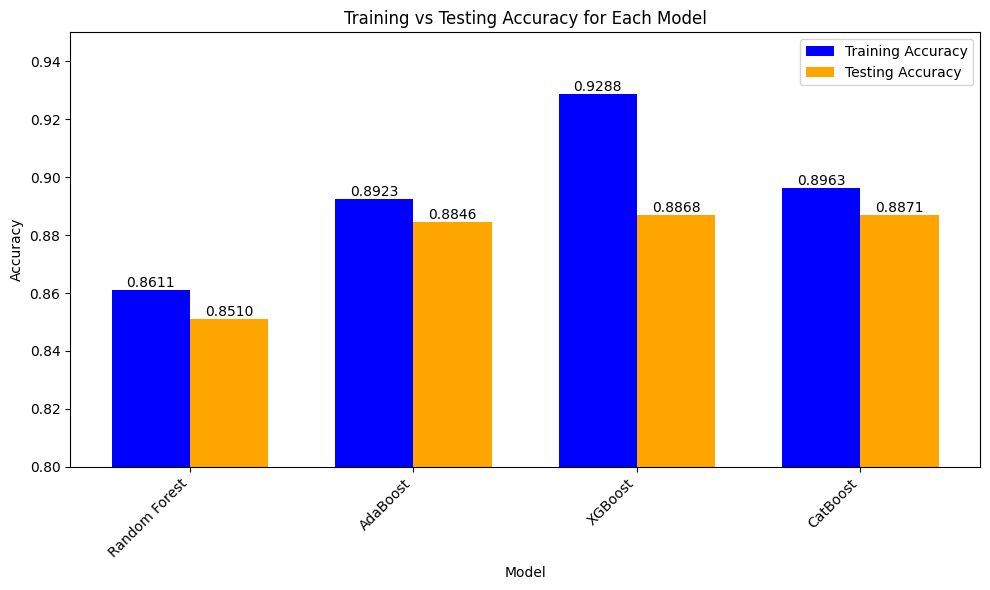

In [20]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score

# 存储模型名称和对应的准确率
model_names = []
train_accuracies = []
test_accuracies = []

# 遍历所有模型配置
for config in model_configs:
    model_name = config['name']
    model_names.append(model_name)
    
    # 加载保存的最佳模型
    best_model = joblib.load(f'{model_name.lower().replace(" ", "_")}_model.pkl')
    
    # 预测
    Y_pred_test = best_model.predict(X_test)
    Y_pred_train = best_model.predict(X_train)
    
    # 计算准确率
    acc_test = accuracy_score(Y_test, Y_pred_test)
    acc_train = accuracy_score(Y_train, Y_pred_train)
    
    # 记录数据
    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)

# 设置柱状图参数
x = np.arange(len(model_names))  # X轴刻度
width = 0.35  # 柱状图宽度

# 创建柱状图
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy', color='blue')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Testing Accuracy', color='orange')

# 添加文本和标签
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy")

ax.set_ylim(0.8, 0.95)
ax.set_title("Training vs Testing Accuracy for Each Model")
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha="right")
ax.legend()

# 显示数值标签（保留四位小数）
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, f'{height:.4f}', 
            ha='center', va='bottom')

# 显示图表
plt.tight_layout()
plt.show()


## 5. Combine into a Hybrid model

### 特征提取

xgb cat meta

In [10]:

# 加载预训练模型
best_xgboost_model = joblib.load('xgboost_model.pkl')
best_catboost_model = joblib.load('catboost_model.pkl')
 

# 定义基学习器列表（名称需唯一）
base_learners = [
    ('catboost', best_catboost_model),
    ('xgbbost', best_xgboost_model) 
]

# 生成概率特征（更丰富的元特征）
def extract_meta_features(models, X):
    meta_features = []
    for name, model in models:
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X)
        else:
            # 若模型不支持概率预测，改用类别标签并独热编码
            pred = model.predict(X).reshape(-1, 1)
            proba = OneHotEncoder().fit_transform(pred).toarray()
        meta_features.append(proba)
    return np.hstack(meta_features)

# 提取训练集和测试集元特征
X_train_2meta = extract_meta_features(base_learners, X_train)
X_test_2meta = extract_meta_features(base_learners, X_test)

# 可选：将元特征与原始特征拼接（增强信息量）
X_train_hybrid = np.hstack([X_train, X_train_2meta])
X_test_hybrid = np.hstack([X_test, X_test_2meta])

# Option 1: Use meta features+raw features for training (need to pass through)
# 方案一：直接使用元特征训练元学习器
meta_learner = LogisticRegression(solver='saga', penalty='l2', C=0.1)
hybrid_2model = meta_learner.fit(X_train_2meta, Y_train)

import pandas as pd

# 保存元特征
pd.DataFrame(X_train_2meta).to_csv('X_train_2meta.csv', index=False)
pd.DataFrame(X_test_2meta).to_csv('X_test_2meta.csv', index=False)


In [11]:
# 使用最佳模型对训练集和测试集进行预测
Y_train_pred = hybrid_2model.predict(X_train_2meta)
Y_test_pred = hybrid_2model.predict(X_test_2meta)

# 计算训练集指标
train_acc = accuracy_score(Y_train, Y_train_pred)
train_pre = precision_score(Y_train, Y_train_pred, average='weighted')
train_f1 = f1_score(Y_train, Y_train_pred, average='weighted')

# 计算测试集指标
test_acc = accuracy_score(Y_test, Y_test_pred)
test_pre = precision_score(Y_test, Y_test_pred, average='weighted')
test_f1 = f1_score(Y_test, Y_test_pred, average='weighted')

# 打印结果
print(f"train- acc: {train_acc:.4f}, pre: {train_pre:.4f}, F1: {train_f1:.4f}")
print(f"test - acc: {test_acc:.4f}, pre: {test_pre:.4f}, F1: {test_f1:.4f}")


train- acc: 0.9298, pre: 0.9303, F1: 0.9297
test - acc: 0.8893, pre: 0.8901, F1: 0.8892


In [12]:
hybrid_2model
joblib.dump(hybrid_2model, 'hybrid_2model.pkl')

['hybrid_2model.pkl']

C:\Users\29548\AppData\Local\Temp\ipykernel_44164\2809681986.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=model_names, y=accuracies, palette="viridis")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


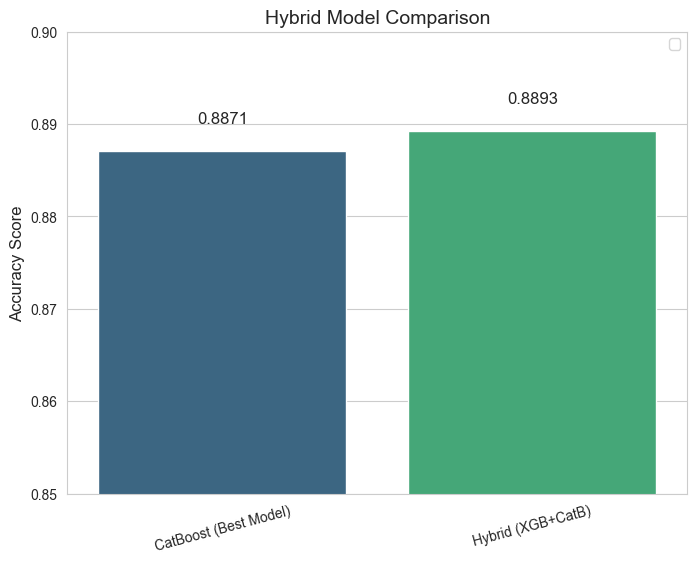

In [13]:
# 计算 XGBoost 及 Hybrid 模型的预测结果
y_pred_catb = best_catboost_model.predict(X_test)  # 基模型 XGBoost
y_pred_h2 = hybrid_2model.predict(X_test_2meta)  # Hybrid-2 (XGB+CatB)
# y_pred_h3 = hybrid_3model.predict(X_train_3meta)  # Hybrid-3 (XGB+CatB+RF)
# y_pred_h4 = hybrid_4model.predict(X_train_4meta)  # Hybrid-4 (XGB+CatB+RF+Ada)

# 计算准确率
acc_xgb = accuracy_score(Y_test, y_pred_catb)
acc_h2 = accuracy_score(Y_test, y_pred_h2)
# acc_h3 = accuracy_score(Y_train, y_pred_h3)
# acc_h4 = accuracy_score(Y_train, y_pred_h4)

# 构建数据
model_names = ['CatBoost (Best Model)', 'Hybrid (XGB+CatB)']
accuracies = [acc_xgb, acc_h2]

# 设置 Seaborn 风格
sns.set_style("whitegrid")

# 创建图形
plt.figure(figsize=(8, 6))

# 画柱状图
barplot = sns.barplot(x=model_names, y=accuracies, palette="viridis")

# 获取每个柱状图的 x 坐标
x_positions = [p.get_x() + p.get_width() / 2 for p in barplot.patches]

# # 画折线
# plt.plot(x_positions, accuracies, marker='o', color='r', linestyle='-', linewidth=2, markersize=8, label="Accuracy Trend")

# 添加数值标注
for i, v in enumerate(accuracies):
    plt.text(x_positions[i], v + 0.003, f"{v:.4f}", ha='center', fontsize=12)

# 图表美化
plt.title("Hybrid Model Comparison", fontsize=14)
plt.ylabel("Accuracy Score", fontsize=12)
plt.ylim(0.85, 0.9)  # 设定 y 轴范围
plt.xticks(rotation=15)  # 旋转标签，避免重叠
plt.legend()  # 显示图例
plt.show()

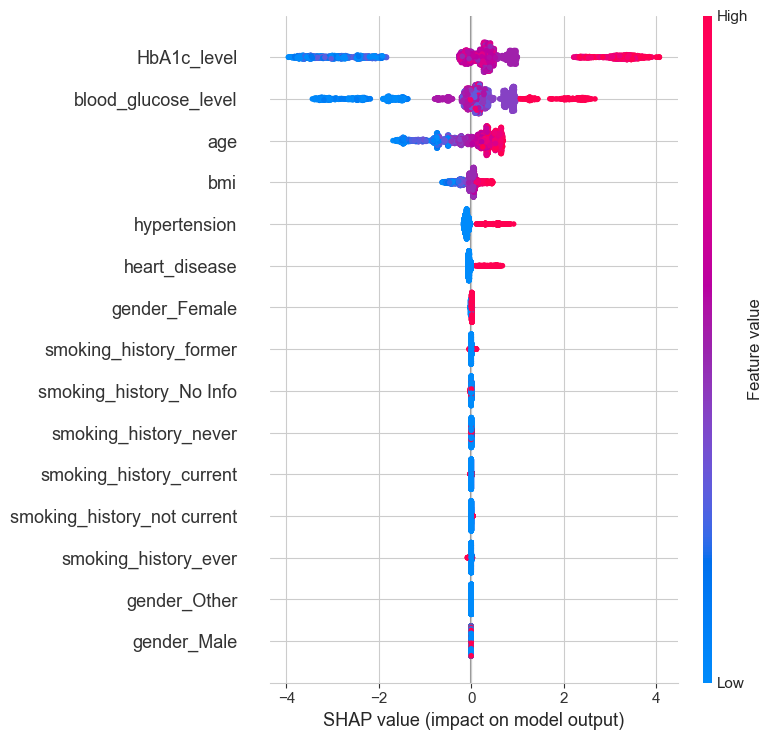

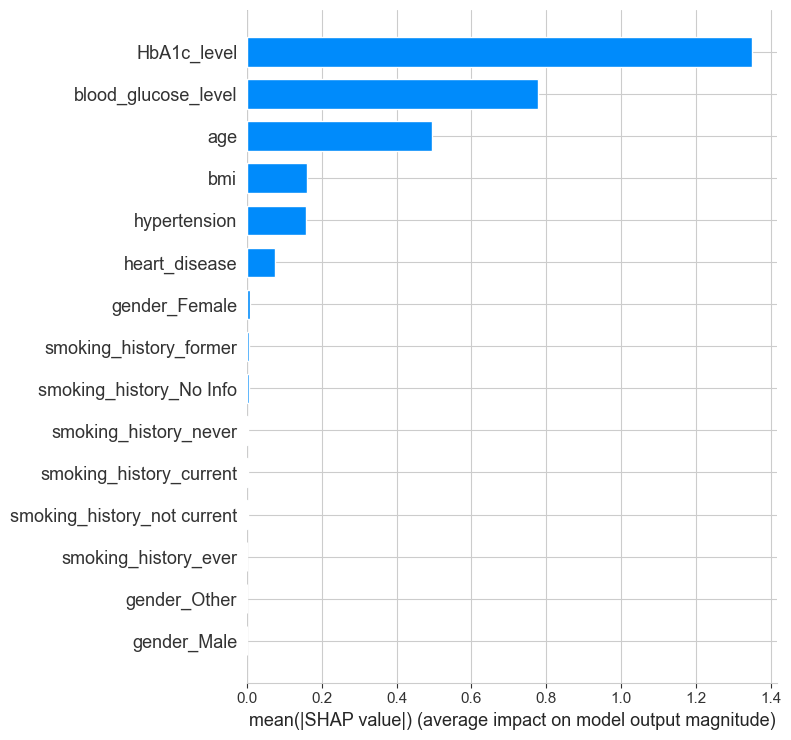

In [13]:
# Initialize SHAP explainer for the hybrid model
explainer = shap.Explainer(best_catboost_model, X_test)

# Compute SHAP values
shap_values = explainer(X_test)

# Summary plot (Feature importance)
shap.summary_plot(shap_values, X_test)

# Bar plot (Feature importance ranking)
shap.summary_plot(shap_values, X_test, plot_type="bar")

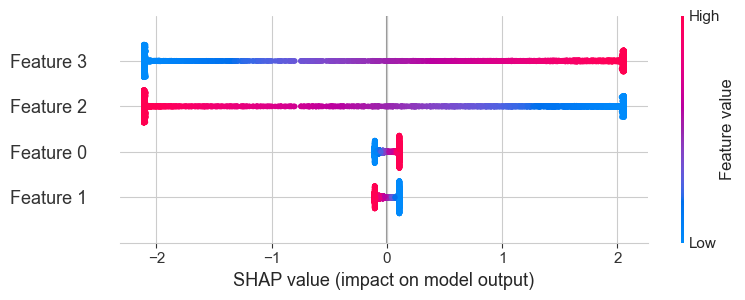

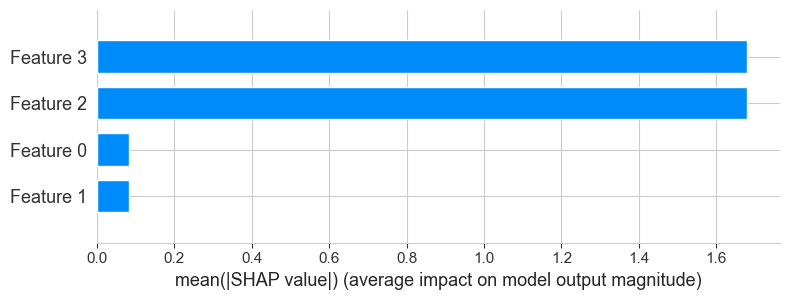

In [14]:
# Initialize SHAP explainer for the hybrid model
explainer = shap.Explainer(hybrid_2model, X_test_2meta)

# Compute SHAP values
shap_values = explainer(X_test_2meta)

# Summary plot (Feature importance)
shap.summary_plot(shap_values, X_test_2meta)

# Bar plot (Feature importance ranking)
shap.summary_plot(shap_values, X_test_2meta, plot_type="bar")